# On the Value of a Draft Pick

Questions answered:
* How many wins is a draft pick worth? 
* How valuable is one pick relative to another?
* How much is there to gain by tanking one spot?
* What's a good draft day trade?
* A good pre-lottery day trade?
* How do the new lottery odds impact this?
* Can you beat the draft, or should teams obey these numbers?
* What are the best and worst drafts of all time? How much does draft quality vary?
* Who are the the most disproportionately good and bad players, relative to their draft position, of all time?

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'white'})
%matplotlib inline

## First, Some Basic Data Manipulation and Cleaning

In [2]:
player_seasons = pd.read_csv('../../Downloads/Seasons_stats.csv') # seasons 1950 - 2017
draft_results = pd.read_csv('all_nba_draft_results.csv') # drafts 1960 - 2017
print('Player season-level data shape: {}'.format(player_seasons.shape))
print('Draft results data shape: {}'.format(draft_results.shape))

Player season-level data shape: (24691, 53)
Draft results data shape: (2671, 26)


In [3]:
# need to drop players drafted < n years ago, where n is number of years considered for AV calculation
max_years_considered = 10
# remove asterisks from players names
player_seasons['Player'] = player_seasons['Player'].replace('\*+', '', regex=True)
# separete id from player name
draft_results['Player'] = draft_results['Player'].str.split('\\').str[0]
# these players were all drafted before the draft data begins
player_seasons = player_seasons.loc[player_seasons.Year >= 1960]
draft_results = draft_results.loc[draft_results.Year <= 2017 - max_years_considered]
# rename for clarity 
draft_results['WS_Total'] = draft_results['WS']

## Create Approximate Value (AV) Statistic

In [4]:
av_table = player_seasons.groupby('Player')['Player','WS'].sum()
# Get twenty highest win shares for each player 
# group by player and get win shares in order
scale_factor = 1
test = player_seasons.groupby('Player').WS.apply(lambda t: t.nlargest(20))
for n in range(0,max_years_considered):
    # get each player's nth best season win share
    ws_n = test.groupby('Player').nth(n)
    av_table = av_table.merge(ws_n.to_frame('ws_{}'.format(n+1))*scale_factor, left_index=True, right_index=True,how='left')
    #print(scale_factor)
    if scale_factor < .04: # rounding issues caused this to miss if == .05, so I'm being sloppy here
        break
    else:
        scale_factor -= 0.05
    
av_table.fillna(0,inplace=True)

In [5]:
# sum of all ws_n columns equals approximate value of the player 
av_table['AV'] = av_table[av_table.columns.difference(['WS'])].sum(axis=1)

In [6]:
av_table['Player'] = av_table.index
av_table.head()

,WS,ws_1,ws_2,ws_3,ws_4,ws_5,ws_6,ws_7,ws_8,ws_9,ws_10,AV,Player
Player,,,,,,,,,,,,,
A.C. Green,104.2,9.4,8.835,7.92,7.31,6.32,5.775,5.32,4.355,3.66,2.86,61.755,A.C. Green
A.J. Bramlett,-0.2,-0.2,0.000,0.00,0.00,0.00,0.000,0.00,0.000,0.00,0.00,-0.200,A.J. Bramlett
A.J. English,1.1,0.9,0.190,0.00,0.00,0.00,0.000,0.00,0.000,0.00,0.00,1.090,A.J. English
A.J. Guyton,0.3,0.3,0.095,-0.09,0.00,0.00,0.000,0.00,0.000,0.00,0.00,0.305,A.J. Guyton
A.J. Hammons,0.0,0.0,0.000,0.00,0.00,0.00,0.000,0.00,0.000,0.00,0.00,0.000,A.J. Hammons


In [7]:
player_seasons['MPG'] = (player_seasons.MP / player_seasons.G)

In [8]:
per_table = player_seasons.groupby('Player')['Player','MPG','PER'].mean()
per_table['Player'] = per_table.index

In [9]:
# note that I drop players with avg < 15 games / yr, since PER does whacky things in small sample sizes
# (e.g. negative or astronomically high values for scrub players)
draft_results = pd.merge(left=draft_results,right=av_table[['Player','WS','AV']],left_on='Player',right_on='Player',how='left')
draft_results = pd.merge(left=draft_results,right=\
    per_table.loc[per_table.MPG>5][['Player','PER']],left_on='Player',right_on='Player',how='left')
draft_results = draft_results.fillna(0)
draft_results.sort_values('Pk').head()

,Rk,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,...,FG%,2P%,3P%,FT%,WS_x,WS/48,WS_Total,WS_y,AV,PER
2070,2661,2007,NBA,1,1,POR,Greg Oden,19.162,C,us,...,0.574,0.574,0.000,0.658,7.3,0.174,7.3,7.3,7.140,17.866667
2043,2634,1980,NBA,1,1,GSW,Joe Barry Carroll,21.327,C-F,us,...,0.474,0.475,0.000,0.747,35.6,0.075,35.6,0.0,0.000,0.000000
2042,2633,1979,NBA,1,1,LAL,Magic Johnson,19.320,G-F,us,...,0.520,0.541,0.303,0.848,155.8,0.225,155.8,155.7,107.970,23.984615
2041,2632,1978,NBA,1,1,POR,Mychal Thompson,23.136,C-F,bs,...,0.504,0.504,0.083,0.655,59.1,0.102,59.1,61.8,43.930,14.950000
2040,2631,1977,NBA,1,1,MIL,Kent Benson,22.171,C,us,...,0.493,0.495,0.206,0.757,33.6,0.103,33.6,36.8,29.345,13.530769


## How Useful is Approximate Value?

Ideally, approximate value would be similar to aggregate career win share, but not perfectly identical. To judge this we'll look qualitatively at how the ranks compare to see whether they make sense. If anyone short of superstar status is in the top few for AV, we'll know there's a problem. 

Next, we'll take a look at the kendall correlation between AV and win share ranks. Kendall correlation is . . . . (explain it) 

In [10]:
# let's take a look at who some of the best are 
# create rankings for AV and career WS
draft_results = draft_results.sort_values(['AV'],ascending=False)
draft_results.insert(1, 'AV_Rank', range(1,len(draft_results)+1))
draft_results = draft_results.sort_values(['WS_Total'],ascending=False)
draft_results.insert(1, 'WS_Rank', range(1,len(draft_results)+1))
draft_results = draft_results.sort_values(['PER'],ascending=False)
draft_results.insert(1, 'PER_Rank', range(1,len(draft_results)+1))

In [11]:
#looks about right.
draft_results[["Player","AV","WS_Total","PER","AV_Rank","WS_Rank","PER_Rank"]].sort_values(['AV_Rank'],ascending=True).head(20)

,Player,AV,WS_Total,PER,AV_Rank,WS_Rank,PER_Rank
1951,Michael Jordan,147.005,214.0,27.373333,1,3,2
2032,Kareem Abdul-Jabbar,144.815,273.4,24.085000,2,1,9
2066,LeBron James,129.740,208.2,27.700000,3,4,1
2023,Oscar Robertson,123.765,189.2,22.807143,4,9,17
2050,David Robinson,122.605,178.7,26.050000,5,11,3
1472,Karl Malone,120.665,234.6,23.642105,6,2,13
1677,Dirk Nowitzki,112.695,201.6,22.178947,7,7,19
1924,Chris Paul,111.060,154.7,25.625000,8,18,4
2042,Magic Johnson,107.970,155.8,23.984615,9,17,10
1975,Jerry West,107.735,162.6,22.807143,10,16,18


In [12]:
# pretty good! AV/WS and PER don't agree quite so well though. 
print(kendalltau(draft_results['AV_Rank'],draft_results['WS_Rank']))
print(kendalltau(draft_results['AV_Rank'],draft_results['PER_Rank']))
print(kendalltau(draft_results['WS_Rank'],draft_results['PER_Rank']))

KendalltauResult(correlation=0.89728969411962289, pvalue=0.0)
KendalltauResult(correlation=0.60397017007350184, pvalue=0.0)
KendalltauResult(correlation=0.57349736527197537, pvalue=0.0)


## What's the Relationship Between Draft Position and Pick Value?

In [13]:
test = draft_results.groupby('Pk').mean()

In [14]:
sd_test = draft_results.groupby('Pk').std()
sd_test['AV_sd'] = sd_test['AV']
sd_test['WS_sd'] = sd_test['WS_Total']
sd_test['PER_sd'] = sd_test['PER']
test = pd.concat([test,sd_test[['AV_sd','WS_sd','PER_sd']]],1)

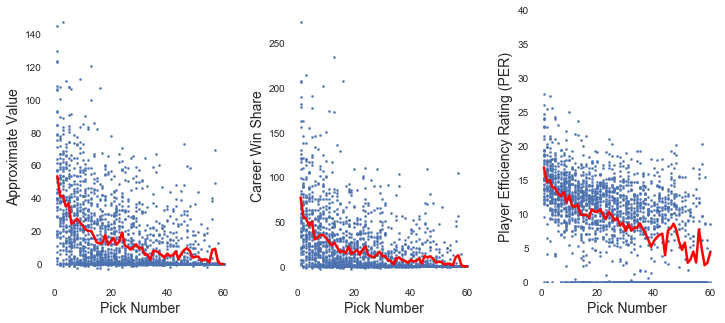

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5) )
fig.subplots_adjust(wspace=.33);
ax[0].scatter(draft_results['Pk'],draft_results['AV'],s=5)
ax[0].plot(test.index,test.AV,color='red',linewidth=2.5)
#ax[0].set_title('Approximate Value')
ax[0].set(xlabel='Pick Number')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].scatter(draft_results['Pk'],draft_results['WS_Total'],s=5)
ax[1].plot(test.index,test.WS_Total,color='red',linewidth=2.5)
#ax[1].set_title('Career Win Share')
ax[1].set(xlabel='Pick Number')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].scatter(draft_results['Pk'],draft_results['PER'],s=5)
ax[2].plot(test.index,test.PER,color='red',linewidth=2.5)
#ax[2].set_title('Career Win Share')
ax[2].set(xlabel='Pick Number')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([0,40])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14);

In [16]:
# all negative, all highly significant 
print('(Pearson Correlation, p-value) between pick number and: \n')
print('Approximate Value: {}'.format(pearsonr(draft_results['Pk'],draft_results['AV'])))
print('Career Win Share: {}'.format(pearsonr(draft_results['Pk'],draft_results['WS_Total'])))
print('Career PER: {}'.format(pearsonr(draft_results['Pk'],draft_results['PER'])))

(Pearson Correlation, p-value) between pick number and: 

Approximate Value: (-0.45003385705882665, 8.1879216571441643e-104)
Career Win Share: (-0.4185968152857284, 1.178208405459885e-88)
Career PER: (-0.48032000959969862, 5.2910922666870941e-120)


In [17]:
test[['AV','WS_Total','PER']]

,AV,WS_Total,PER
Pk,,,
1,53.376146,77.179167,16.851194
2,41.166562,55.137500,14.662030
3,41.270521,53.310417,14.957180
4,34.977812,45.420833,13.967901
5,36.889062,50.179167,13.762301
6,24.310000,30.179167,12.921874
7,25.607187,31.985417,12.643815
8,27.543542,35.085417,13.184042
9,25.300521,34.922917,11.659836


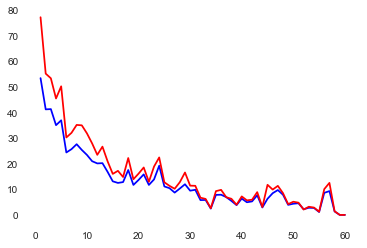

In [18]:
plt.plot(test['AV'],color='Blue')
plt.plot(test['WS_Total'],color='Red');

In [19]:
# fit smoothing curves to this data
xx = np.linspace(1,test.index.max(), 1000)
z_av = np.polyfit(test.index,test.AV,5)
z_ws = np.polyfit(test.index,test.WS_Total,5)
z_per = np.polyfit(test.index,test.PER,5)
p_av = np.poly1d(z_av)
p_ws = np.poly1d(z_ws)
p_per = np.poly1d(z_per)

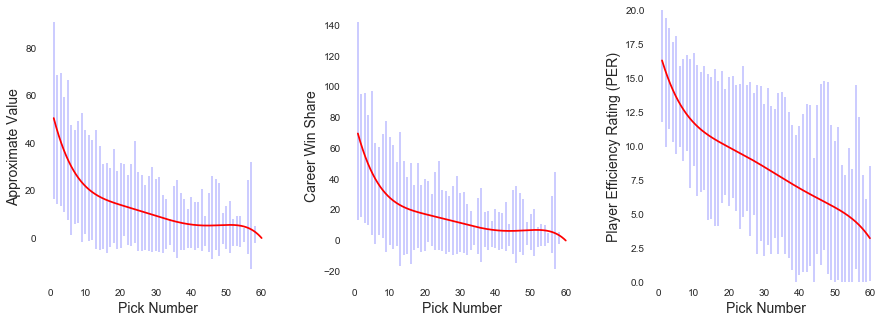

In [20]:
# sd grows at tail since there haven't always been 30 teams and per becomes unstable for low playing time players
fig, ax = plt.subplots(1, 3, figsize=(15, 5) )
fig.subplots_adjust(wspace=.33);
ax[0].plot(xx,p_av(xx),c='Red')
ax[0].set(xlabel='Pick Number')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].plot(xx,p_ws(xx),c='Red')
ax[1].set(xlabel='Pick Number')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].plot(xx,p_per(xx),c='Red')
ax[2].set(xlabel='Pick Number')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([0,20])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14)
ax[0].errorbar(test.index, test.AV, yerr=test.AV_sd,lw=0.4,linestyle='None',c='Blue')
ax[1].errorbar(test.index, test.WS_Total, yerr=test.WS_sd,lw=0.4,linestyle='None',c='Blue')
ax[2].errorbar(test.index, test.PER, yerr=test.PER_sd,lw=0.4,linestyle='None',c='Blue')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False);

In [21]:
eav_df = pd.DataFrame(p_av(test.index))
ews_df = pd.DataFrame(p_ws(test.index))
eper_df = pd.DataFrame(p_per(test.index))
eav_df.index = test.index
ews_df.index = test.index
eper_df.index = test.index
eav_df.columns = ['Smooth_AV']
ews_df.columns = ['Smooth_WS']
eper_df.columns = ['Smooth_PER']
test = pd.concat([test, eav_df],1)
test = pd.concat([test, ews_df],1)
test = pd.concat([test, eper_df],1)
test[['Smooth_AV','Smooth_WS','Smooth_PER','AV_sd','WS_sd','PER_sd']]

,Smooth_AV,Smooth_WS,Smooth_PER,AV_sd,WS_sd,PER_sd
Pk,,,,,,
1,50.340095,69.276452,16.288597,37.280917,64.466240,5.095358
2,45.035381,61.527716,15.488958,27.109944,39.958865,4.750629
3,40.408434,54.774342,14.782076,27.892589,42.639075,3.705521
4,36.388297,48.913121,14.158353,24.082682,35.790971,3.648025
5,32.908903,43.847873,13.608830,29.363571,46.949411,4.340322
6,29.908908,39.489222,13.125173,23.192031,32.916742,2.969072
7,27.331530,35.754358,12.699647,19.896481,28.714441,3.772848
8,25.124388,32.566807,12.325095,21.541310,33.849573,3.535649
9,23.239338,29.856202,11.994923,27.057583,42.659025,4.761650


In [22]:
expected_av_vector = np.asarray(test[['Smooth_AV']]).T
expected_ws_vector = np.asarray(test[['Smooth_WS']]).T
expected_per_vector = np.asarray(test[['Smooth_PER']]).T

## How the Lottery Works
Source: http://www.nba.com/magic/news/how-nba-draft-lottery-works

* Worst 14 teams assigned n of 1,001 4-number combinations 
* 14 numbered ping pong balls are placed in a glass drum
* Four are drawn and not replaced. The team owning this 4-number combo gets pick 1 
* This is repeated for picks 2 and 3 
* The remaining lottery teams are placed in order of descending record in order to determine picks 5 - 14 

A team, then, can draft at worst three picks below the inverse of their record's ranking. Imagine the least probable top-three pick seanario: the 14th, 13th, and 12th worst teams pick one through three. The fourth pick, then, is guaranteed to the worst team, the fifth pick is given to the second worst team, and the sixth pick is then given to the third worst team, and so on down the line. This is why, despite only the first three picks being determined by random permutations of numbered ping pong balls, each pick up until the 14th has uncertain ownership up until the top three picks are determined.

In [23]:
odds = pd.read_csv('/Users/jledoux/Downloads/draft_odds.csv')
odds = odds.replace(0.000, '---')
print(odds.head(14))

    inverse_rank      1      2      3      4      5      6      7      8  \
0              1   0.25  0.215  0.178  0.357    ---    ---    ---    ---   
1              2  0.199  0.188  0.171  0.319  0.123    ---    ---    ---   
2              3  0.156  0.157  0.156  0.226  0.265   0.04    ---    ---   
3              4  0.119  0.126  0.133  0.099  0.351   0.16  0.012    ---   
4              5  0.088  0.097  0.107    ---  0.261   0.36  0.084  0.004   
5              6  0.063  0.071  0.081    ---    ---  0.439  0.305   0.04   
6              7  0.043  0.049  0.058    ---    ---    ---  0.599  0.232   
7              8  0.028  0.033  0.039    ---    ---    ---    ---  0.724   
8              9  0.017   0.02  0.024    ---    ---    ---    ---    ---   
9             10  0.011  0.013  0.016    ---    ---    ---    ---    ---   
10            11  0.008  0.009  0.012    ---    ---    ---    ---    ---   
11            12  0.007  0.008   0.01    ---    ---    ---    ---    ---   
12          

In [24]:
odds = pd.read_csv('/Users/jledoux/Downloads/draft_odds.csv') # re-load to keep in original usable format

## What's the Draft-Pick Value of an End of Season Ranking?

In [25]:
odds2 = odds.drop('inverse_rank',1)
odds2 = np.asmatrix(odds2)
odds2 = np.dot(odds2,expected_av_vector.T)

odds3 = odds.drop('inverse_rank',1)
odds3 = np.asmatrix(odds3)
odds3 = np.dot(odds3,expected_ws_vector.T)

odds4 = odds.drop('inverse_rank',1)
odds4 = np.asmatrix(odds4)
odds4 = np.dot(odds4,expected_per_vector.T)

odds2 = pd.DataFrame(odds2)
odds3 = pd.DataFrame(odds3)
odds4 = pd.DataFrame(odds4)
odds2.columns = ['Expected_AV']
odds3.columns = ['Expected_WS']
odds4.columns = ['Expected_PER']

In [26]:
odds = pd.concat([odds, pd.DataFrame(odds2)],axis=1)
odds = pd.concat([odds, pd.DataFrame(odds3)],axis=1)
odds = pd.concat([odds, pd.DataFrame(odds4)],axis=1)

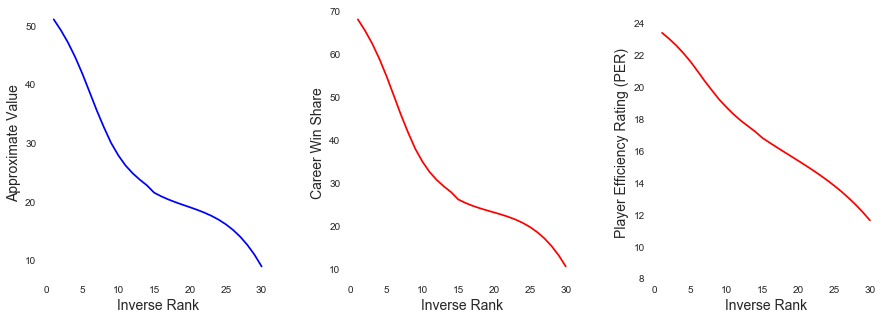

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5) )
fig.subplots_adjust(wspace=.33);
ax[0].plot(odds['inverse_rank'],odds['Expected_AV'],color='Blue')
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].plot(odds['inverse_rank'],odds['Expected_WS'],color='Red')
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].plot(odds['inverse_rank'],odds['Expected_PER'],color='Red')
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([8,25])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14);

In [28]:
odds[['inverse_rank','Expected_AV','Expected_WS', 'Expected_PER']]

,inverse_rank,Expected_AV,Expected_WS,Expected_PER
0,1,51.146849,68.193521,23.383774
1,2,49.291033,65.561759,23.008644
2,3,47.169092,62.538962,22.587623
3,4,44.685665,58.986782,22.104707
4,5,41.857143,54.926456,21.568997
5,6,38.750138,50.469242,20.963382
6,7,35.612136,45.969593,20.341645
7,8,32.718827,41.822578,19.762902
8,9,30.061727,38.028828,19.200726
9,10,27.953555,35.034798,18.722885


## What's the Value of Tanking One Position?

In [29]:
odds.loc[odds['inverse_rank'] > 1, 'tank_value_AV'] = -odds['Expected_AV'].diff()
odds.loc[odds['inverse_rank'] > 1, 'tank_value_WS'] = -odds['Expected_WS'].diff()
odds.loc[odds['inverse_rank'] > 1, 'tank_value_PER'] = -odds['Expected_PER'].diff()
odds = odds.sort_values(['tank_value_AV'],ascending=False)
odds.insert(1,'av_tank_rank',range(1,len(odds)+1))
odds = odds.sort_values(['tank_value_WS'],ascending=False)
odds.insert(1,'ws_tank_rank',range(1,len(odds)+1))
odds = odds.sort_values(['tank_value_PER'],ascending=False)
odds.insert(1,'per_tank_rank',range(1,len(odds)+1))
odds = odds.sort_values(['inverse_rank'])

odds[['Expected_AV','Expected_WS','Expected_PER','tank_value_AV','tank_value_WS','tank_value_PER','av_tank_rank','ws_tank_rank','per_tank_rank']]

,Expected_AV,Expected_WS,Expected_PER,tank_value_AV,tank_value_WS,tank_value_PER,av_tank_rank,ws_tank_rank,per_tank_rank
0,51.146849,68.193521,23.383774,NaN,NaN,NaN,30,30,30
1,49.291033,65.561759,23.008644,1.855816,2.631762,0.375129,10,9,16
2,47.169092,62.538962,22.587623,2.121941,3.022797,0.421022,7,7,12
3,44.685665,58.986782,22.104707,2.483427,3.552180,0.482915,6,6,7
4,41.857143,54.926456,21.568997,2.828522,4.060327,0.535710,4,4,5
5,38.750138,50.469242,20.963382,3.107005,4.457214,0.605616,2,2,2
6,35.612136,45.969593,20.341645,3.138002,4.499650,0.621736,1,1,1
7,32.718827,41.822578,19.762902,2.893310,4.147015,0.578743,3,3,3
8,30.061727,38.028828,19.200726,2.657100,3.793750,0.562176,5,5,4
9,27.953555,35.034798,18.722885,2.108172,2.994030,0.477841,8,8,8


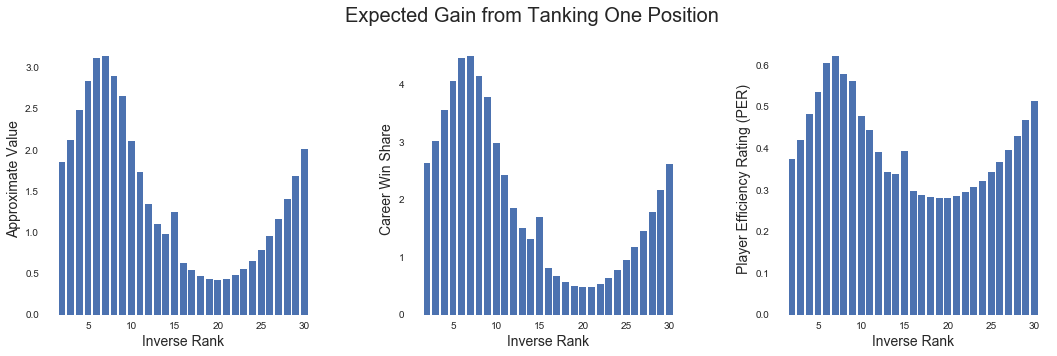

In [30]:
# the spike represents the gain of being a lottery team vs. missing out
# this also means no playoff appearance, however, so you probably shouldn't tank there
fig, ax = plt.subplots(1, 3, figsize=(18, 5) )
fig.subplots_adjust(wspace=.33)
fig.suptitle('Expected Gain from Tanking One Position',fontsize=20)
ax[0].bar(odds.inverse_rank,odds.tank_value_AV)
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].bar(odds.inverse_rank,odds.tank_value_WS);
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].bar(odds.inverse_rank,odds.tank_value_PER)
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14);

## How Does This Change Under the New Lottery Rules?

In [31]:
new_odds = pd.read_csv('/Users/jledoux/Downloads/new_odds.csv') # re-load to keep in original usable format

In [32]:
odds2 = new_odds.drop('inverse_rank',1)
odds2 = np.asmatrix(odds2)
odds2 = np.dot(odds2,expected_av_vector.T)

odds3 = new_odds.drop('inverse_rank',1)
odds3 = np.asmatrix(odds3)
odds3 = np.dot(odds3,expected_ws_vector.T)

odds4 = new_odds.drop('inverse_rank',1)
odds4 = np.asmatrix(odds4)
odds4 = np.dot(odds4,expected_per_vector.T)

odds2 = pd.DataFrame(odds2)
odds3 = pd.DataFrame(odds3)
odds4 = pd.DataFrame(odds4)
odds2.columns = ['Expected_AV']
odds3.columns = ['Expected_WS']
odds4.columns = ['Expected_PER']

In [33]:
new_odds = pd.concat([new_odds, pd.DataFrame(odds2)],axis=1)
new_odds = pd.concat([new_odds, pd.DataFrame(odds3)],axis=1)
new_odds = pd.concat([new_odds, pd.DataFrame(odds4)],axis=1)

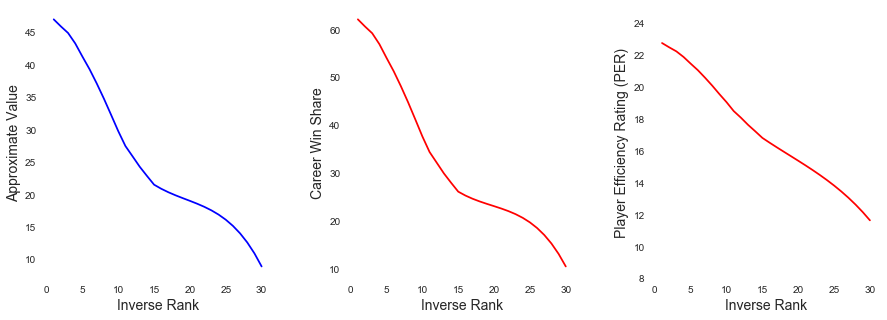

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5) )
fig.subplots_adjust(wspace=.33);
ax[0].plot(new_odds['inverse_rank'],new_odds['Expected_AV'],color='Blue')
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].plot(new_odds['inverse_rank'],new_odds['Expected_WS'],color='Red')
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].plot(new_odds['inverse_rank'],new_odds['Expected_PER'],color='Red')
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([8,25])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14);

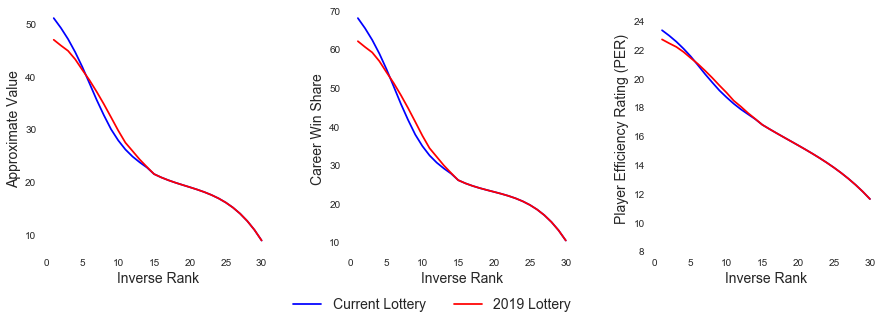

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5) )
fig.subplots_adjust(wspace=.33);
ax[0].plot(odds['inverse_rank'],odds['Expected_AV'],color='Blue')
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].plot(odds['inverse_rank'],odds['Expected_WS'],color='Blue')
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].plot(odds['inverse_rank'],odds['Expected_PER'],color='Blue')
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([8,25])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14)
ax[0].plot(new_odds['inverse_rank'],new_odds['Expected_AV'],color='Red')
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].plot(new_odds['inverse_rank'],new_odds['Expected_WS'],color='Red')
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].plot(new_odds['inverse_rank'],new_odds['Expected_PER'],color='Red')
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].set_ylim([8,25])
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14)


from matplotlib.lines import Line2D
l1 = Line2D(xdata= new_odds['inverse_rank'], ydata = new_odds['Expected_PER'], c="Red")
l2 = Line2D(xdata= new_odds['inverse_rank'], ydata = new_odds['Expected_PER'], c="Blue")
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.figlegend([l2,l1], ['Current Lottery','2019 Lottery'],fontsize=14,\
             loc='lower center', bbox_to_anchor=(0.4, 0),fancybox=True, shadow=True,\
             ncol=2);

In [36]:
odds[['inverse_rank','Expected_AV','Expected_WS', 'Expected_PER']]

,inverse_rank,Expected_AV,Expected_WS,Expected_PER
0,1,51.146849,68.193521,23.383774
1,2,49.291033,65.561759,23.008644
2,3,47.169092,62.538962,22.587623
3,4,44.685665,58.986782,22.104707
4,5,41.857143,54.926456,21.568997
5,6,38.750138,50.469242,20.963382
6,7,35.612136,45.969593,20.341645
7,8,32.718827,41.822578,19.762902
8,9,30.061727,38.028828,19.200726
9,10,27.953555,35.034798,18.722885


In [37]:
new_odds.loc[new_odds['inverse_rank'] > 1, 'tank_value_AV'] = -new_odds['Expected_AV'].diff()
new_odds.loc[new_odds['inverse_rank'] > 1, 'tank_value_WS'] = -new_odds['Expected_WS'].diff()
new_odds.loc[new_odds['inverse_rank'] > 1, 'tank_value_PER'] = -new_odds['Expected_PER'].diff()
new_odds = new_odds.sort_values(['tank_value_AV'],ascending=False)
new_odds.insert(1,'av_tank_rank',range(1,len(new_odds)+1))
new_odds = new_odds.sort_values(['tank_value_WS'],ascending=False)
new_odds.insert(1,'ws_tank_rank',range(1,len(new_odds)+1))
new_odds = new_odds.sort_values(['tank_value_PER'],ascending=False)
new_odds.insert(1,'per_tank_rank',range(1,len(new_odds)+1))
new_odds = new_odds.sort_values(['inverse_rank'])

new_odds[['Expected_AV','Expected_WS','Expected_PER','tank_value_AV','tank_value_WS','tank_value_PER','av_tank_rank','ws_tank_rank','per_tank_rank']]

,Expected_AV,Expected_WS,Expected_PER,tank_value_AV,tank_value_WS,tank_value_PER,av_tank_rank,ws_tank_rank,per_tank_rank
0,47.040081,62.206597,22.746637,NaN,NaN,NaN,30,30,30
1,45.952476,60.702434,22.477693,1.087605,1.504163,0.268943,17,16,28
2,44.941658,59.302387,22.225574,1.010818,1.400047,0.252120,18,18,29
3,43.332763,57.027393,21.875943,1.608895,2.274995,0.349630,10,9,17
4,41.309712,54.146836,21.455609,2.023051,2.880556,0.420334,6,6,10
5,39.353382,51.358010,21.047213,1.956330,2.788826,0.408396,8,7,13
6,37.163515,48.236991,20.577262,2.189867,3.121019,0.469951,5,5,6
7,34.822999,44.894240,20.082375,2.340516,3.342752,0.494887,3,3,5
8,32.336135,41.342448,19.553053,2.486864,3.551792,0.529322,2,2,2
9,29.819924,37.735827,19.046763,2.516211,3.606621,0.506290,1,1,4


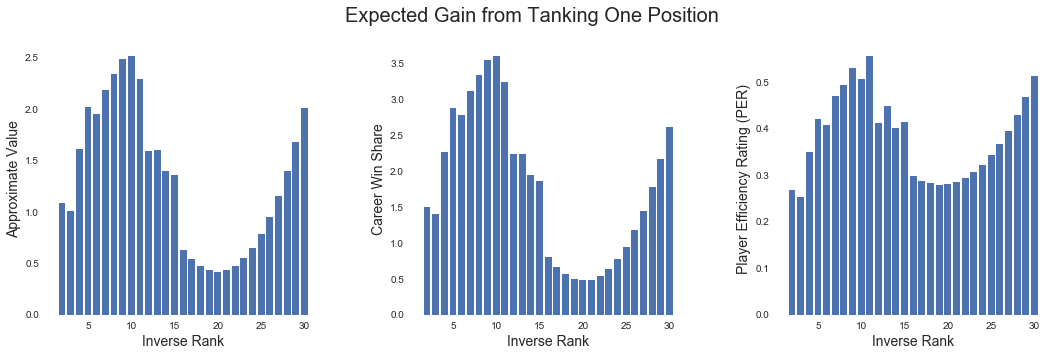

In [38]:
# the spike represents the gain of being a lottery team vs. missing out
# this also means no playoff appearance, however, so you probably shouldn't tank there
fig, ax = plt.subplots(1, 3, figsize=(18, 5) )
fig.subplots_adjust(wspace=.33)
fig.suptitle('Expected Gain from Tanking One Position',fontsize=20)
ax[0].bar(new_odds.inverse_rank,new_odds.tank_value_AV)
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].bar(new_odds.inverse_rank,new_odds.tank_value_WS);
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].bar(new_odds.inverse_rank,new_odds.tank_value_PER)
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14);

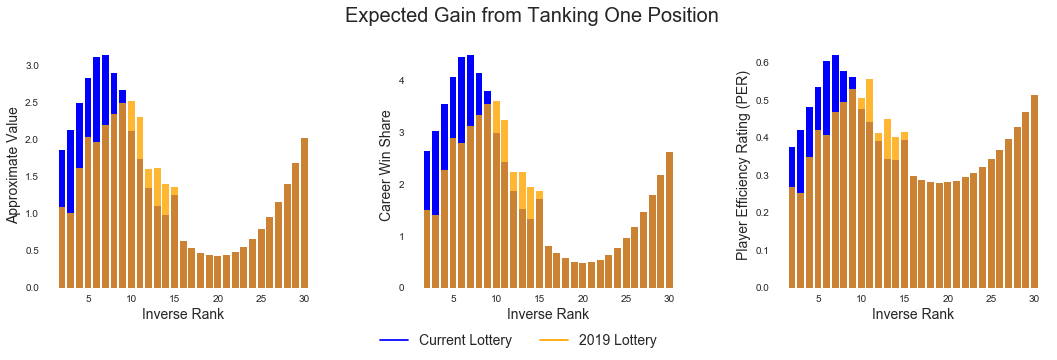

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5) )
fig.subplots_adjust(wspace=.33)
fig.suptitle('Expected Gain from Tanking One Position',fontsize=20)
ax[0].bar(odds.inverse_rank,odds.tank_value_AV,color='B')
ax[0].set(xlabel='Inverse Rank')
ax[0].set(ylabel='Approximate Value')
ax[0].xaxis.label.set_size(14)
ax[0].yaxis.label.set_size(14);
ax[1].bar(odds.inverse_rank,odds.tank_value_WS,color='B');
ax[1].set(xlabel='Inverse Rank')
ax[1].set(ylabel='Career Win Share')
ax[1].xaxis.label.set_size(14)
ax[1].yaxis.label.set_size(14);
ax[2].bar(odds.inverse_rank,odds.tank_value_PER,color='B')
ax[2].set(xlabel='Inverse Rank')
ax[2].set(ylabel='Player Efficiency Rating (PER)')
ax[2].xaxis.label.set_size(14)
ax[2].yaxis.label.set_size(14)


ax[0].bar(new_odds.inverse_rank,new_odds.tank_value_AV,alpha=0.8,color='Orange')
ax[1].bar(new_odds.inverse_rank,new_odds.tank_value_WS,alpha=0.8,color='Orange');
ax[2].bar(new_odds.inverse_rank,new_odds.tank_value_PER,alpha=0.8,color='Orange')

l1 = Line2D(xdata= new_odds['inverse_rank'], ydata = new_odds['Expected_PER'], c="Orange")
l2 = Line2D(xdata= new_odds['inverse_rank'], ydata = new_odds['Expected_PER'], c="Blue")
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
box = ax[2].get_position()
ax[2].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.figlegend([l2,l1], ['Current Lottery','2019 Lottery'],fontsize=14,\
             loc='lower center', bbox_to_anchor=(0.4, 0),fancybox=True, shadow=True,\
             ncol=2);

In [40]:
print(new_odds.subtract(odds).tank_value_PER.sum())
print(new_odds.subtract(odds).tank_value_WS.sum())
print(new_odds.subtract(odds).tank_value_AV.sum())

-0.63713708162
-5.98692446808
-4.10676833365
